In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week09_policy_II/td3_and_sac/logger.py

    !pip -q install gymnasium[mujoco]
    !pip -q install tensorboardX

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

??? ????????????? ????????????? ?????????? Windows ??? Linux.

???????????? ????? ?????????? ?? Microsoft Store:

https://aka.ms/wslstore



# Continuous Control


In this notebook you will solve continuous control environment using either [Twin Delayed DDPG (TD3)](https://arxiv.org/pdf/1802.09477.pdf) or [Soft Actor-Critic (SAC)](https://arxiv.org/pdf/1801.01290.pdf). Both are off-policy algorithms that are current go-to algorithms for continuous control tasks.

**Select one** of these two algorithms (TD3 or SAC) to implement. Both algorithms are extensions of basic [Deep Deterministic Policy Gradient (DDPG)](https://arxiv.org/abs/1509.02971) algorithm, and DDPG is kind of "DQN with another neural net approximating greedy policy", and all that differs is a set of stabilization tricks:
* TD3 trains deterministic policy, while SAC uses *stochastic policy*. This means that for SAC you can solve exploration-exploitation trade-off by simple sampling from policy, while in TD3 you will have to add noise to your actions.
* TD3 proposes to stabilize targets by adding a *clipped noise* to actions, which slightly prevents overestimation. In SAC, we formally switch to formalism of Maximum Entropy RL and add *entropy bonus* into our value function.

Also both algorithms utilize a *twin trick*: train two critics and use pessimistic targets by taking minimum from two proposals. Standard trick with target networks is also necessary. We will go through all these tricks step-by-step.

SAC is probably less clumsy scheme than TD3, but requires a bit more code to implement. More detailed description of algorithms can be found in Spinning Up documentation:
* on [DDPG](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)
* on [TD3](https://spinningup.openai.com/en/latest/algorithms/td3.html)
* on [SAC](https://spinningup.openai.com/en/latest/algorithms/sac.html)

## Environment

In [2]:
import gymnasium as gym
import numpy as np

First, we will create an instance of the environment.

In [3]:
!pip install gymnasium[mujoco]

In [4]:
env = gym.make("Ant-v4", render_mode="rgb_array")

# we want to look inside
env.reset()

# examples of states and actions
print("observation space: ", env.observation_space,
      "\nobservations:", env.reset()[0])
print("action space: ", env.action_space,
      "\naction_sample: ", env.action_space.sample())

observation space:  Box(-inf, inf, (27,), float64) 
observations: [ 0.83244872  1.09977182  0.05306467 -0.09156647 -0.04027795  0.00128637
  0.08896518 -0.0961498  -0.06868807 -0.06057166 -0.00894347 -0.04820715
 -0.0289179  -0.00670809  0.24804756  0.01549839  0.13028182  0.04681801
 -0.01213311  0.05052135 -0.07242319  0.1376258   0.11186782  0.00360349
 -0.13418217 -0.07370646 -0.17273885]
action space:  Box(-1.0, 1.0, (8,), float32) 
action_sample:  [ 0.3432489   0.27925178  0.8691265  -0.178561    0.6454964   0.32705504
  0.90043724 -0.7729169 ]


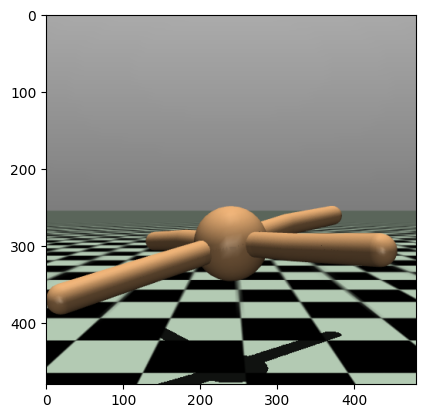

In [5]:
import matplotlib.pyplot as plt

plt.imshow(env.render())

Let's run random policy and see how it looks.

In [6]:
class RandomActor():
    def get_action(self, states):
        assert len(states.shape) == 1, "can't work with batches"
        return env.action_space.sample()

In [7]:
s, _ = env.reset()
rewards_per_step = []
actor = RandomActor()

for i in range(10000):
    a = actor.get_action(s)
    s, r, terminated, truncated, _ = env.step(a)

    rewards_per_step.append(r)

    if terminated or truncated:
        s, _ = env.reset()
        print("done: ", i)

done:  999
done:  1076
done:  1162
done:  1225
done:  1304
done:  1357
done:  1398
done:  2398
done:  2416
done:  2470
done:  2628
done:  2701
done:  2890
done:  2910
done:  2978
done:  3063
done:  3109
done:  3244
done:  3399
done:  3499
done:  3592
done:  3642
done:  3780
done:  3814
done:  3853
done:  4114
done:  4169
done:  5169
done:  5252
done:  5277
done:  5325
done:  5495
done:  5551
done:  6551
done:  6712
done:  6810
done:  6826
done:  6983
done:  7117
done:  7246
done:  7335
done:  7509
done:  7556
done:  7620
done:  7641
done:  7667
done:  7684
done:  8684
done:  8770
done:  9770
done:  9785
done:  9817


So, basically most episodes are 1000 steps long (then happens termination by time), though sometimes we are terminated earlier if simulation discovers some obvious reasons to think that we crashed our ant. Important thing about continuous control tasks like this is that we receive non-trivial signal at each step: 

In [8]:
rewards_per_step[100:110]

[0.3689055336264637,
 -0.23569113397540375,
 -0.10880849735793596,
 -0.06234163924152103,
 0.363552241504864,
 0.8424307081388753,
 0.8863322999611971,
 0.26049611162921105,
 -0.6564482328918557,
 -0.1478292715053371]

This dense signal will guide our optimizations. It also partially explains why off-policy algorithms are more effective and sample-efficient than on-policy algorithms like PPO: 1-step targets are already quite informative.

In [9]:
env.close()

We will add only one wrapper to our environment to simply write summaries, mainly, the total reward during an episode.

In [10]:
from logger import TensorboardSummaries as Summaries

env = gym.make("Ant-v4", render_mode="rgb_array")
env = Summaries(env, "MyFirstWalkingAnt");

state_dim = env.observation_space.shape[0]  # dimension of state space (27 numbers)
action_dim = env.action_space.shape[0]      # dimension of action space (8 numbers)

## Models

Let's start with *critic* model. On the one hand, it will function as an approximation of $Q^*(s, a)$, on the other hand it evaluates current actor $\pi$ and can be viewed as $Q^{\pi}(s, a)$. This critic will take both state $s$ and action $a$ as input and output a scalar value. Recommended architecture is 3-layered MLP.

**Danger:** when models have a scalar output it is a good rule to squeeze it to avoid unexpected broadcasting, since [batch_size, 1] broadcasts with many tensor sizes.

In [11]:
import torch
import torch.nn as nn
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def get_qvalues(self, states, actions):
        '''
        input:
            states - tensor, (batch_size x features)
            actions - tensor, (batch_size x actions_dim)
        output:
            qvalues - tensor, critic estimation, (batch_size)
        '''
        qvalues = self.net(torch.cat([states, actions], dim=-1)).squeeze(-1)

        assert len(qvalues.shape) == 1 and qvalues.shape[0] == states.shape[0]

        return qvalues

Next, let's define a policy, or an actor $\pi$. Use architecture, similar to critic (3-layered MLP). The output depends on algorithm:

For **TD3**, model *deterministic policy*. You should output `action_dim` numbers in range $[-1, 1]$. Unfortunately, deterministic policies lead to problems with stability and exploration, so we will need three "modes" of how this policy can be operating:
* First one - greedy - is a simple feedforward pass through network that will be used to train the actor.
* Second one - exploration mode - is when we need to add noise (e.g. Gaussian) to our actions to collect more diverse data. 
* Third mode - "clipped noised" - will be used when we will require a target for critic, where we need to somehow "noise" our actor output, but not too much, so we add *clipped noise* to our output:
$$\pi_{\theta}(s) + \varepsilon, \quad \varepsilon = \operatorname{clip}(\epsilon, -0.5, 0.5), \epsilon \sim \mathcal{N}(0, \sigma^2 I)$$

In [12]:
# template for TD3; template for SAC is below
class TD3_Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()
        )

    def get_action(self, states, std_noise=0.1):
        '''
        Used to collect data by interacting with environment,
        so your have to add some noise to actions.
        input:
            states - numpy, (batch_size x features)
        output:
            actions - numpy, (batch_size x actions_dim)
        '''
        # no gradient computation is required here since we will use this only for interaction
        with torch.no_grad():
            states_t = torch.as_tensor(states, dtype=torch.float32, device=DEVICE)
            actions = self.net(states_t)
            noise   = torch.normal(0, std_noise, size=actions.shape, device=actions.device)
            actions = (actions + noise).clamp(-1, 1)
            actions = actions.cpu().numpy()

            assert isinstance(actions, (list,np.ndarray)), "convert actions to numpy to send into env"
            assert actions.max() <= 1. and actions.min() >= -1, "actions must be in the range [-1, 1]"
            return actions

    def get_best_action(self, states):
        '''
        Will be used to optimize actor. Requires differentiable w.r.t. parameters actions.
        input:
            states - PyTorch tensor, (batch_size x features)
        output:
            actions - PyTorch tensor, (batch_size x actions_dim)
        '''
        actions = self.net(states)

        assert actions.requires_grad, "you must be able to compute gradients through actions"
        return actions

    def get_target_action(self, states, std_noise=0.2, clip_eta=0.5):
        '''
        Will be used to create target for critic optimization.
        Returns actions with added "clipped noise".
        input:
            states - PyTorch tensor, (batch_size x features)
        output:
            actions - PyTorch tensor, (batch_size x actions_dim)
        '''
        # no gradient computation is required here since we will use this only for interaction
        with torch.no_grad():
            actions = self.net(states)
            noise   = torch.normal(0, std_noise, size=actions.shape,
                                   device=actions.device).clamp(-clip_eta, clip_eta)
            actions = actions + noise

            # actions can fly out of [-1, 1] range after added noise
            return actions.clamp(-1, 1)

For **SAC**, model *gaussian policy*. This means policy distribution is going to be multivariate normal with diagonal covariance. The policy head will predict the mean and covariance, and it should be guaranteed that covariance is non-negative. **Important:** the way you model covariance strongly influences optimization procedure, so here are some options: let $f_{\theta}$ be the output of covariance head, then:
* use exponential function $\sigma(s) = \exp(f_{\theta}(s))$
* transform output to $[-1, 1]$ using `tanh`, then project output to some interval $[m, M]$, where $m = -20$, $M = 2$ and then use exponential function. This will guarantee the range of modeled covariance is adequate. So, the resulting formula is:
$$\sigma(s) = \exp^{m + 0.5(M - m)(\tanh(f_{\theta}(s)) + 1)}$$
* `softplus` operation $\sigma(s) = \log(1 + \exp^{f_{\theta}(s)})$ seems to work poorly here. o_O

**Note**: `torch.distributions.Normal` already has everything you will need to work with such policy after you modeled mean and covariance, i.e. sampling via reparametrization trick (see `rsample` method) and compute log probability (see `log_prob` method).

There is one more problem with gaussian distribution. We need to force our actions to be in $[-1, 1]$ bound. To achieve this, model unbounded gaussian $\mathcal{N}(\mu_{\theta}(s), \sigma_{\theta}(s)^2I)$, where $\mu$ can be arbitrary. Then every time you have samples $u$ from this gaussian policy, squash it using $\operatorname{tanh}$ function to get a sample from $[-1, 1]$:
$$u \sim \mathcal{N}(\mu, \sigma^2I)$$
$$a = \operatorname{tanh}(u)$$

**Important:** after that you are required to use change of variable formula every time you compute likelihood (see appendix C in [paper on SAC](https://arxiv.org/pdf/1801.01290.pdf) for details):
$$\log p(a \mid \mu, \sigma) = \log p(u \mid \mu, \sigma) - \sum_{i = 1}^D \log (1 - \operatorname{tanh}^2(u_i)),$$
where $D$ is `action_dim`. In practice, add something like 1e-6 inside logarithm to protect from computational instabilities.

In [13]:
# template for SAC
from torch.distributions import Normal

class SAC_Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.hidden = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256),       nn.ReLU()
        )
        self.mu_head     = nn.Linear(256, action_dim)
        self.logstd_head = nn.Linear(256, action_dim)

    def apply(self, states):
        '''
        For given batch of states samples actions and also returns its log prob.
        input:
            states - PyTorch tensor, (batch_size x features)
        output:
            actions - PyTorch tensor, (batch_size x action_dim)
            log_prob - PyTorch tensor, (batch_size)
        '''
        x       = self.hidden(states)
        mu      = self.mu_head(x)
        log_std = self.logstd_head(x).clamp(-20, 2)
        std     = log_std.exp()
        dist    = Normal(mu, std)
        z       = dist.rsample()                  # re-parameterisation
        actions = torch.tanh(z)
        log_prob = (dist.log_prob(z) - torch.log(1 - actions.pow(2) + 1e-6)).sum(-1)

        return actions, log_prob

    def get_action(self, states):
        '''
        Used to interact with environment by sampling actions from policy
        input:
            states - numpy, (batch_size x features)
        output:
            actions - numpy, (batch_size x actions_dim)
        '''
        # no gradient computation is required here since we will use this only for interaction
        with torch.no_grad():

            # hint: you can use `apply` method here
            actions, _ = self.apply(torch.as_tensor(states,
                                                    dtype=torch.float32, device=DEVICE))
            actions = actions.cpu().numpy()

            assert isinstance(actions, (list,np.ndarray)), "convert actions to numpy to send into env"
            assert actions.max() <= 1. and actions.min() >= -1, "actions must be in the range [-1, 1]"
            return actions

## ReplayBuffer

The same as in DQN. You can copy code from your DQN assignment, just check that it works fine with continuous actions (probably it is). 

Let's recall the interface:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [14]:
class ReplayBuffer():
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        storage = self._storage
        maxsize = self._maxsize
        if len(storage) >= maxsize:         # FIFO
            storage.pop(0)
        storage.append(data)
            # add data to storage

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        storage = self._storage
        idxes = np.random.randint(0, len(storage), size=batch_size)
            # randomly generate batch_size integers
            # to be used as indexes of samples

        batch = [storage[i] for i in idxes]
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

            # collect <s,a,r,s',done> for each index

        return states, actions, rewards.astype(np.float32), next_states, dones.astype(np.float32)
            # <states>, <actions>, <rewards>, <next_states>, <is_done>

In [15]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(),
                   1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [16]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for t in range(n_steps):

        # select action using policy with exploration
        a = agent.get_action(s)

        ns, r, terminated, truncated, _ = env.step(a)

        exp_replay.add(s, a, r, ns, terminated)

        s = env.reset()[0] if terminated or truncated else ns

        sum_rewards += r

    return sum_rewards, s

In [17]:
#testing your code.
exp_replay = ReplayBuffer(2000)
actor = TD3_Actor(state_dim, action_dim).to(DEVICE)

state, _ = env.reset()
play_and_record(state, actor, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + (state_dim,)
    assert act_batch.shape == (
        10, action_dim), "actions batch should have shape (10, 8) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"

print("Well done!")

Well done!


## Initialization

Let's start initializing our algorithm. Here is our hyperparameters:

In [18]:
gamma=0.99                    # discount factor
max_buffer_size = 10**5       # size of experience replay
start_timesteps = 5000        # size of experience replay when start training
timesteps_per_epoch=1         # steps in environment per step of network updates
batch_size=128                # batch size for all optimizations
max_grad_norm=10              # max grad norm for all optimizations
tau=0.005                     # speed of updating target networks
policy_update_freq = 2        # frequency of actor update; vanilla choice is 2 for TD3 or 1 for SAC
alpha=0.1                     # temperature for SAC

# iterations passed
n_iterations = 0

Here is our experience replay:

In [19]:
# experience replay
exp_replay = ReplayBuffer(max_buffer_size)

Here is our models: *two* critics and one actor.

In [20]:
# models to train
actor = TD3_Actor(state_dim, action_dim).to(DEVICE)
critic1 = Critic(state_dim, action_dim).to(DEVICE)
critic2 = Critic(state_dim, action_dim).to(DEVICE)

To stabilize training, we will require **target networks** - slow updating copies of our models. In **TD3**, both critics and actor have their copies, in **SAC** it is assumed that only critics require target copies while actor is always used fresh.

In [21]:
# target networks: slow-updated copies of actor and two critics
target_critic1 = Critic(state_dim, action_dim).to(DEVICE)
target_critic2 = Critic(state_dim, action_dim).to(DEVICE)
target_actor = TD3_Actor(state_dim, action_dim).to(DEVICE)  # comment this line if you chose SAC

# initialize them as copies of original models
target_critic1.load_state_dict(critic1.state_dict())
target_critic2.load_state_dict(critic2.state_dict())
target_actor.load_state_dict(actor.state_dict())            # comment this line if you chose SAC 

<All keys matched successfully>

In continuous control, target networks are usually updated using exponential smoothing:
$$\theta^{-} \leftarrow \tau \theta + (1 - \tau) \theta^{-},$$
where $\theta^{-}$ are target network weights, $\theta$ - fresh parameters, $\tau$ - hyperparameter. This util function will do it:

In [22]:
def update_target_networks(model, target_model):
    for param, target_param in zip(model.parameters(), target_model.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

Finally, we will have three optimization procedures to train our three models, so let's welcome our three Adams:

In [23]:
# optimizers: for every model we have
opt_actor = torch.optim.Adam(actor.parameters(), lr=3e-4)
opt_critic1 = torch.optim.Adam(critic1.parameters(), lr=3e-4)
opt_critic2 = torch.optim.Adam(critic2.parameters(), lr=3e-4)

In [24]:
# just to avoid writing this code three times
def optimize(name, model, optimizer, loss):
    '''
    Makes one step of SGD optimization, clips norm with max_grad_norm and 
    logs everything into tensorboard
    '''
    loss = loss.mean()
    optimizer.zero_grad()
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()

    # logging
    env.writer.add_scalar(name, loss.item(), n_iterations)
    env.writer.add_scalar(name + "_grad_norm", grad_norm.item(), n_iterations)

## Critic target computation

Finally, let's discuss our losses for critic and actor.

To train both critics we would like to minimize MSE using 1-step targets: for one sampled transition $(s, a, r, s')$ it should look something like this:
$$y(s, a) = r + \gamma V(s').$$

How do we evaluate next state and compute $V(s')$? Well, technically Monte-Carlo estimation looks simple:
$$V(s') \approx Q(s', a')$$
where (important!) $a'$ is a sample from our current policy $\pi(a' \mid s')$.

But out actor $\pi$ will be actually trained to search for actions $a'$ where our critic gives big estimates, and this straightforward approach leads to serious overesimation issues. We require some hacks. First, we will use target networks for $Q$ (and **TD3** also uses target network for $\pi$). Second, we will use *two* critics and take minimum across their estimations:
$$V(s') = \min_{i = 1,2} Q^{-}_i(s', a'),$$
where $a'$ is sampled from target policy $\pi^{-}(a' \mid s')$ in **TD3** and from fresh policy $\pi(a' \mid s')$ in **SAC**.

###### And the last but not the least:
* in **TD3** to compute $a'$ use *mode with clipped noise* that will prevent our policy from exploiting narrow peaks in our critic approximation;
* in **SAC** add (estimation of) entropy bonus in next state $s'$:
$$V(s') = \min_{i = 1,2} Q^{-}_i(s', a') - \alpha \log \pi (a' \mid s')$$

In [25]:
def compute_critic_target(rewards, next_states, is_done):
    '''
    Important: use target networks for this method! Do not use "fresh" models except fresh policy in SAC!
    input:
        rewards - PyTorch tensor, (batch_size)
        next_states - PyTorch tensor, (batch_size x features)
        is_done - PyTorch tensor, (batch_size)
    output:
        critic target - PyTorch tensor, (batch_size)
    '''
    with torch.no_grad():
        next_actions = target_actor.get_target_action(next_states)
        q1_next = target_critic1.get_qvalues(next_states, next_actions)
        q2_next = target_critic2.get_qvalues(next_states, next_actions)
        q_next  = torch.min(q1_next, q2_next)
        critic_target = rewards + gamma * (1 - is_done) * q_next

    assert not critic_target.requires_grad, "target must not require grad."
    assert len(critic_target.shape) == 1, "dangerous extra dimension in target?"

    return critic_target

To train actor we want simply to maximize
$$\mathbb{E}_{a \sim \pi(a \mid s)} Q(s, a) \to \max_{\pi}$$

* in **TD3**, because of deterministic policy, the expectation reduces:
$$Q(s, \pi(s)) \to \max_{\pi}$$
* in **SAC**, use reparametrization trick to compute gradients and also do not forget to add entropy regularizer to motivate policy to be as stochastic as possible:
$$\mathbb{E}_{a \sim \pi(a \mid s)} Q(s, a) - \alpha \log \pi(a \mid s) \to \max_{\pi}$$

**Note:** We will use (fresh) critic1 here as Q-functon to "exploit". You can also use both critics and again take minimum across their estimations (this is done in original implementation of **SAC** and not done in **TD3**), but this seems to be not of high importance.

In [26]:
def compute_actor_loss(states):
    '''
    Returns actor loss on batch of states
    input:
        states - PyTorch tensor, (batch_size x features)
    output:
        actor loss - PyTorch tensor, (batch_size)
    '''
    # make sure you have gradients w.r.t. actor parameters
    actions = actor.get_best_action(states)

    assert actions.requires_grad, "actions must be differentiable with respect to policy parameters"

    # compute actor loss
    actor_loss = -critic1.get_qvalues(states, actions)
    return actor_loss

# Pipeline

Finally combining all together and launching our algorithm. Your goal is to reach at least 1000 average reward during evaluation after training in this ant environment (*since this is a new hometask, this threshold might be updated, so at least just see if your ant learned to walk in the rendered simulation*).

* rewards should rise more or less steadily in this environment. There can be some drops due to instabilities of algorithm, but it should eventually start rising after 100K-200K iterations. If no progress in reward is observed after these first 100K-200K iterations, there is a bug.
* gradient norm appears to be quite big for this task, it is ok if it reaches 100-200 (we handled it with clip_grad_norm). Consider everything exploded if it starts growing exponentially, then there is a bug.

In [27]:
seed = 40
np.random.seed(seed)
env.reset(seed=seed)
torch.manual_seed(seed);

In [28]:
!pip install ipywidgets

In [29]:
from tqdm.notebook import trange

reset_out = env.reset(seed=seed)
interaction_state = reset_out[0] if isinstance(reset_out, tuple) else reset_out

random_actor = RandomActor()

for n_iterations in trange(0, 1000000, timesteps_per_epoch):
    # if experience replay is small yet, no training happens
    # we also collect data using random policy to collect more diverse starting data
    if len(exp_replay) < start_timesteps:
        _, interaction_state = play_and_record(interaction_state, random_actor, env, exp_replay, timesteps_per_epoch)
        continue

    # perform a step in environment and store it in experience replay
    _, interaction_state = play_and_record(interaction_state, actor, env, exp_replay, timesteps_per_epoch)

    # sample a batch from experience replay
    states, actions, rewards, next_states, is_done = exp_replay.sample(batch_size)

    # move everything to PyTorch tensors
    states = torch.tensor(states, device=DEVICE, dtype=torch.float)
    actions = torch.tensor(actions, device=DEVICE, dtype=torch.float)
    rewards = torch.tensor(rewards, device=DEVICE, dtype=torch.float)
    next_states = torch.tensor(next_states, device=DEVICE, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=DEVICE,
        dtype=torch.float
    )

    # losses
    critic1_loss = (critic1.get_qvalues(states, actions) -
                compute_critic_target(rewards, next_states, is_done)).pow(2)
    optimize("critic1", critic1, opt_critic1, critic1_loss)

    critic2_loss = (critic2.get_qvalues(states, actions) -
                compute_critic_target(rewards, next_states, is_done)).pow(2)
    optimize("critic2", critic2, opt_critic2, critic2_loss)

    # actor update is less frequent in TD3
    if n_iterations % policy_update_freq == 0:

        actor_loss   = compute_actor_loss(states)
        optimize("actor", actor, opt_actor, actor_loss)

        # update target networks
        update_target_networks(critic1, target_critic1)
        update_target_networks(critic2, target_critic2)
        update_target_networks(actor, target_actor)                     # comment this line if you chose SAC

  0%|          | 0/1000000 [00:00<?, ?it/s]

Computation time ~2:30 hours

## Evaluation

In [30]:
def evaluate(env, actor, n_games=1, t_max=1000):
    '''
    Plays n_games and returns rewards and rendered games
    '''
    rewards = []

    for _ in range(n_games):
        s, _ = env.reset()

        R = 0
        for _ in range(t_max):
            # select action for final evaluation of your policy
            action = actor.get_action(s)

            assert (action.max() <= 1).all() and  (action.min() >= -1).all()

            s, r, terminated, truncated, _ = env.step(action)

            R += r

            if terminated or truncated:
                break

        rewards.append(R)
    return np.array(rewards)

In [31]:
# evaluation will take some time!
sessions = evaluate(env, actor, n_games=20)
score = sessions.mean()
print(f"Your score: {score}")

assert score >= 1000, "Needs more training?"
print("Well done!")

Your score: 2431.0450939055213
Well done!


In [32]:
env.close()

## Record

In [33]:
from gymnasium.wrappers import RecordVideo

# let's hope this will work
# don't forget to pray
with gym.make("Ant-v4", render_mode="rgb_array") as env, RecordVideo(
    env=env, video_folder="./videos"
) as env_monitor:
    # note that t_max is 300, so collected reward will be smaller than 1000
    evaluate(env_monitor, actor, n_games=1, t_max=300)

MoviePy - Building video C:\RL\Practical_RL\week09_policy_II\td3_and_sac\videos\rl-video-episode-0.mp4.
MoviePy - Writing video C:\RL\Practical_RL\week09_policy_II\td3_and_sac\videos\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\RL\Practical_RL\week09_policy_II\td3_and_sac\videos\rl-video-episode-0.mp4


In [35]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

### Report

We'd like to collect some statistics about computational resources you spent on this task. Please, report:
* which GPU or CPU you used: <YOUR ANSWER>
* number of iterations you used for training: <YOUR ANSWER>
* wall-clock time spent (on computation =D): <YOUR ANSWER>